# Step 2

In step 2 you will be using **Pytorch** to import MNIST, train a neural network on MNIST, find examples that "fool" that trained network, and, if you're a 6505 student, propose a way to deal with these examples.

## Question 1

Start by importing both the training and testing MNIST datasets using DataLoaders and the torchvision provided datasets. You can set both the training and testing batch size to be whatever you feel is best.

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [3]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [4]:
#splitting the dataset in 50,000 for training the model and 10,000 for perterbed images
train_set, splitted_train_set = torch.utils.data.random_split(train_data, [50000, 10000])

In [5]:
from torch.utils.data import DataLoader

In [6]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_set, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=10000, 
                                          shuffle=True, 
                                          num_workers=1),
    'perturbed'  : torch.utils.data.DataLoader(splitted_train_set, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=1),
}

## Question 2

Define a network with the following architecture:

Conv2d (input channels=1, output channels = 15,kernel size = 5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Conv2d (input channels=15, output channels = 30,kernel size = 5)
$\rightarrow$
Dropout2d (p = 0.5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Linear(input dimension = 480, hidden units = 64)
$\rightarrow$
ReLU
$\rightarrow$
Dropout (p=0.5)
$\rightarrow$
Linear(input dimension = 64, hidden units = 10)
$\rightarrow$
LogSoftMax

In [7]:
import torch.nn as nn

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=15,            
                kernel_size=5,              
                stride=1,                                     
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),                      
                
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=15,              
                out_channels=30,
                kernel_size=5,
            ),
            nn.Dropout(0.50),                          
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.linear = nn.Sequential(
            nn.Linear(in_features=480, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=64, out_features=10),
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = x.view(x.size(0), -1)       
        x = self.linear(x)
        output = nn.LogSoftmax(x)
        return x, output

In [9]:
import copy
model = CNN()
model2 = copy.deepcopy(model)
print(model)
print(model2)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=480, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

## Question 3

Train the network you defined in the previous question on MNIST, using the optimizer and the number of training epochs you deem appropriate. Use a cross-entropy loss. Each epoch test your model on the testing dataset and print the value of the accuracy that you achieve. Produce a plot of the loss against the number of epochs.

**Note**: Do not be overly worried about the accuracy that you achieve with your model. It should be upwards of 95% at the very least, but you won't get bonus marks for training a model that has 99.x% accuracy.

In [10]:
from torch import optim

In [11]:
# hyperparameters
learning_rate = 0.01
momentum=0.9

In [12]:
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
loss_func = nn.CrossEntropyLoss()

In [13]:
optimizer2 = optim.SGD(model2.parameters(), learning_rate, momentum)

In [14]:
optimizer, optimizer2

(SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0
 ),
 SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0
 ))

In [15]:
from torch.autograd import Variable

In [16]:
num_epochs = 2

In [17]:
epoch_loss = []
e = []
def train(num_epochs, model, loaders):
    
    model.train()
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        total_train_loss = 0
        for i, (images, labels) in enumerate(loaders['train']):
            
            b_x = Variable(images)   #x
            b_y = Variable(labels)   #y
            output = model(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # ask pytorch to not accumulates gradient, forward pass
            optimizer.zero_grad()
            
            loss.backward()             
            optimizer.step()
            
            #capturing training loss in an epoch
            total_train_loss += loss.item()
        else:
            # testing the model after every epoch
            print("Epoch {} - Training loss: {}".format(epoch, total_train_loss/total_step))
            epoch_loss.append(total_train_loss/total_step)
            e.append(epoch)
            
            # Test the model
            model.eval()
            with torch.no_grad():
                for images, labels in loaders['test']:
                    test_output, last_layer = model(images)
                    pred_y = torch.max(test_output, 1)[1].data.squeeze()
                    accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
        print("=====================================================================")

In [18]:
train(num_epochs, model, loaders)

Epoch 0 - Training loss: 0.6383922972381115
Test Accuracy of the model on the 10000 test images: 0.96
Epoch 1 - Training loss: 0.10007520801387727
Test Accuracy of the model on the 10000 test images: 0.98


In [19]:
# checking output from model
dataset = next(iter(loaders['test']))
images, labels = dataset

actual_labels = labels[:10].numpy()

test_output, last_layer = model(images[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_labels}')

Prediction number: [4 5 8 9 7 0 6 8 5 7]
Actual number: [4 8 8 9 7 0 6 8 5 7]


In [20]:
import matplotlib.pyplot as plt

In [21]:
# graph epoch vs epoch_loss
e, epoch_loss

([0, 1], [0.6383922972381115, 0.10007520801387727])

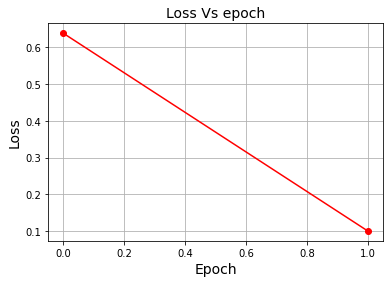

In [22]:
plt.plot(e, epoch_loss, color='red', marker='o')
plt.title('Loss Vs epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.show()

## Question 4

### Part 1

Suppose that you have a fully trained network, and that you wanted to find images that "fooled" it, i.e., images that are misclassified by your network.

One simple approach would be to take an input image, and then alter it in the direction of ascent of the gradient of the loss w.r.t to the pixels of that input image. Mathematically:

$
\begin{equation}
x^´ = x + \epsilon \,\text{sign}\left[\nabla_x \mathcal{L(\theta,x,y}) \right]
\end{equation}
$,

where $x^´$ is the (perturbed) image you hope will fool the classifier, $x$ is the input image, $y$ is the label of the original image, $\theta$ are the network parameters, $\epsilon$ is a hyperparameter controlling the strength of the perturbation, and $\mathcal{L}$ is the loss.

Implement this in Pytorch, using the model you trained in question 3. Generate one $x'$ for all the images in the MNIST testing set, keep the $x^´$ that sucessfully fool your model, alongside their original labels and their predicted (wrong) labels, and print out the accuracy of your model in the perturbed testing set (all the $x^´$ obtained from the images in the original testing set using the equation above), for the following epsilons: $\epsilon = 0,0.05,0.15,0.25$

**Hint**: A line of code similar to "data.requires_grad = True" is needed somewhere in your solution

In [23]:
# creating an attack function to generate perturbed dataset and testing on the model from step3
# in this func, we are creating a fast gradient sign attack, which we will use to fool our network
# clean input image, epsilon value, data_grad= gradient of the loss w.r.t input img.
def fgsm_attack(image, epsilon, data_grad):
    
    # get the gradient
    sign_data_grad = data_grad.sign()
    
    # adjusting the input image, 𝑥+𝜖 sign[∇𝑥 L(theta,x,y)] 
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [24]:
def test(model, device, test_loader, epsilon ):

    correct = 0
    adv_examples = []

    for data, target in test_loader:

        data, target = data.to(device), target.to(device)

        # Important for Attack, setting requires_grad=True
        data.requires_grad = True
        output = model(data)[0]
        init_pred = output.max(1, keepdim=True)[1]

        # checking prediction, if wrong, just move on
        if init_pred.item() != target.item():
            continue

        loss = loss_func(output, target)
        model.zero_grad()
        loss.backward()

        # Collecting datagrad
        data_grad = data.grad.data

        # calling attack func here
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # getting prediction on perturbed image
        output = model(perturbed_data)[0]
        final_pred = torch.max(output, 1)[1].data.squeeze()
        
        if final_pred.item() == target.item():
            # increasing correct predicted images and checking for epsilon 0
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # accuracy for each epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples

In [25]:
accuracies = []
examples = []
epsilons = [0,0.05,0.15,0.25]
device="cpu"

# Run test for each epsilon
for eps in epsilons:
    # here we are using the 10,000 images we kept aside
    acc, ex = test(model, device , loaders['perturbed'], eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9770 / 10000 = 0.977
Epsilon: 0.05	Test Accuracy = 9091 / 10000 = 0.9091
Epsilon: 0.15	Test Accuracy = 5009 / 10000 = 0.5009
Epsilon: 0.25	Test Accuracy = 898 / 10000 = 0.0898


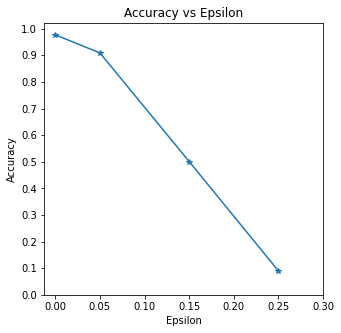

In [26]:
import numpy as np
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Part 2

Show some of the images that fooled your network in part 1 (plt.imshow will come in handy), making sure to include both what their original and perturbed labels were in the title of your plot. Does it make sense to you that these images are fooling your network? Why or why not?

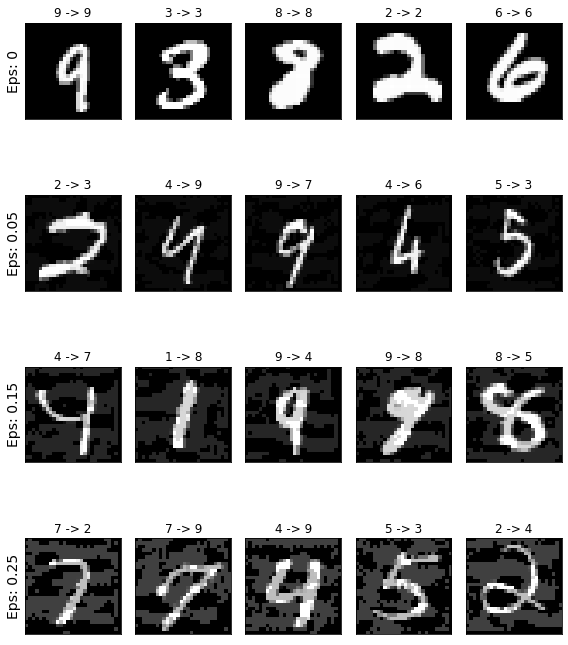

In [27]:
# plotting the graphs, for the prediction on each epsilon 
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Does it make sense to you that these images are fooling your network? Why or why not?

Yes, what we are actually doing through this FGSM attack is, we are changing the way of parameter update.



Traditional approach: After calculating the loss, we use backpropogation to calculate the gradient and update the parameters.



Using FGSM: It is a white-box attack and we are using this appraoch to fool our model, in which it calculates the gradient of the loss with respect to the input image and create a new image that maximizes the loss. The new images is called perturbed image and the expression is as follows:

$ perturbed_image = input_image + \epsilon \,\text{sign}\left[\nabla_x \mathcal{L(\theta,x,y}) \right] $


In this we are not trying to train the model again, that's why we are not taking gradient with respect to model parameters, so that the model parameters remain constant.



-- L(theta, x, y) is the loss that is used to train the network.


-- The attack, backpropagates the gradient back to the input data to calculate ∇𝑥 L(theta,x,y)


-- Then, it adjusts the input image with a small step (epsilon) in the direction of sign (which will mazimize the loss) -- sign[∇𝑥 L(theta,x,y). The larger the epsilon the larger will be the step in the direction that will minimize the loss


-- perturbed_image = image + epsilon*sign_data_grad

## Question 5 (6505 only)

Can you think of a way to make your network more robust to these perturbed images? Does your proposal have drawbacks? Run any experiments you feel are needed to prove your claims.

**Note**: You are not expected to find a perfect solution, just something that makes sense and has some evidence backing it up. You will be marked on the persuasiveness of your argument/experiments and how much sense your proposal makes, not the overall improvements in robustness you achieve (however, if your proposal worsens the problem, then that's a pretty solid hint you're going in the wrong direction).

Solution: One approach which can come handy to increase the efficiency of our model is to use the perturbed images while training the model, This method is commonly known as Adversarial training. But the drawback of this appraoch is, we have to again train our model which will eventually increase the training time.

And obviously using perturbed images to train the model does not gurantee 100% resistance to adversial attacks, but it reduces the number of errors.

Here I am training a new model with 50,000 images (First using original image and then FGSM attack image of the original image) and while testing the model I am giving 10,000 perturbed images with 0,0.05,0.15,0.25 as epsilon values.

This concept is implemented into the code by feeding both the original and the perturbed training set into the architecture at the same time. Here i am using both types of data for adversarial training to prevent the loss in accuracy on the original set of data. The network will starts from the checkpoint where it is already trained during adversarial training to prevent from accuracy decrease on clean data during further training.

In [28]:
epoch_loss = []
e = []

def adversarial_train(num_epochs, model, loaders):
    
    model2.train()
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        total_train_loss = 0
        for images, labels in (loaders['train']):
            
            b_x = Variable(images)  
            b_y = Variable(labels)   
            
            optimizer2.zero_grad()
            output = model2(b_x)[0]               
            loss = loss_func(output, b_y)
            loss.backward()             
            optimizer2.step()
            
            #capturing training loss in an epoch
            total_train_loss += loss.item()
            
            
            # perturbed image
            images.requires_grad = True
            output = model2(images)[0]
            loss = loss_func(output, labels)
            model2.zero_grad()
            loss.backward()
            data_grad = images.grad.data
            perturbed_data = fgsm_attack(images, 0.25, data_grad)
            
            # Adversarial training
            b_x = Variable(perturbed_data)
            optimizer2.zero_grad()
            output = model2(perturbed_data)[0]               
            loss = loss_func(output, labels)
            loss.backward()             
            optimizer2.step()
            
            total_train_loss += loss.item()
            
        else:
            print("Epoch {} - Training loss: {}".format(epoch, total_train_loss/total_step))
            epoch_loss.append(total_train_loss/total_step)
            e.append(epoch)
            
            # Test the model
            model2.eval()
            with torch.no_grad():
                for images, labels in loaders['test']:
                    test_output, last_layer = model2(images)
                    pred_y = torch.max(test_output, 1)[1].data.squeeze()
                    accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
        print("=====================================================================")

In [29]:
num_epochs = 3
adversarial_train(num_epochs, model2, loaders)

Epoch 0 - Training loss: 1.7365897480845451
Test Accuracy of the model on the 10000 test images: 0.97
Epoch 1 - Training loss: 0.7194606839381158
Test Accuracy of the model on the 10000 test images: 0.98
Epoch 2 - Training loss: 0.5376305292528123
Test Accuracy of the model on the 10000 test images: 0.98


In [30]:
# now testing the new model on the same 10,000 images I used above with different epsilon values

In [31]:
accuracies = []
examples = []
epsilons = [0,0.05,0.15,0.25]
device="cpu"

# Run test for each epsilon
for eps in epsilons:
    # here we are using the 10,000 images we kept aside
    acc, ex = test(model2, device , loaders['perturbed'], eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9844 / 10000 = 0.9844
Epsilon: 0.05	Test Accuracy = 9727 / 10000 = 0.9727
Epsilon: 0.15	Test Accuracy = 9295 / 10000 = 0.9295
Epsilon: 0.25	Test Accuracy = 8547 / 10000 = 0.8547


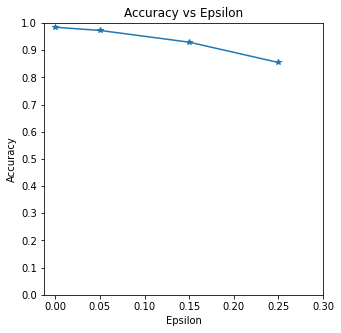

In [32]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

As we can clearly observe when we trained the model using original images and the FGSM attacked images, the overall accuracy in case of epsilon 0 dropped from 98% to 94%. However, in case of epsilon 0.0, 0.15, 0.25 I am observing a drastic improvement in the model accuracy. 

## Does your proposal have drawbacks?

Although after using the adversarial training approach, we can see a drastic change in the model prediction, but our model is effective on a specific type of attack the model is trained on. If we try with different attacks, our adversarial trained model will not perform better, we need to further investigate and evaluate for better adversarial defense

## References

[1] “Training using Pytorch” [Online]. 
Available: https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118 [Accessed on 14th March 2022]

[2] “Adversarial Attack” [Online]. 
Available: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html#fast-gradient-sign-attack 
[Accessed on 15th March 2022]

[3] “Attack and defense” [Online]. 
Available: https://towardsdatascience.com/adversarial-attack-and-defense-on-neural-networks-in-pytorch-82b5bcd9171
[Accessed on 16th March 2022]